In [1]:
import numpy as np
import math
import itertools
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import qiskit
import qiskit.quantum_info as qi 
# import warnings
# warnings.filterwarnings('ignore')
import time
import networkx as nx
from scipy.linalg import expm
from scipy.optimize import minimize, Bounds
from qiskit import QuantumCircuit, Aer, execute
import networkx as nx
from QAOA_locality import *
from QAOA_class import * 

In [2]:
def depth_scaling(H, p_c_start=1, p_c_stop=15, epsilon = 0.1, seeds=100):

    check = False
    for p_c in range(p_c_start, p_c_stop+1):       
        Q1 = QAOA(p_c,H)
        for s in range(1,seeds +1):
            Q1.run_heuristic_LW()  
            if Q1.q_error <= epsilon:
                check = True 
                break
        if check:
            break

    return Q1, p_c

2

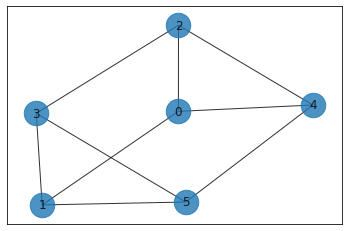

In [3]:
n = 6  # Number of nodes in graph
G = nx.random_regular_graph(3,n)
H = get_Hamiltonian(G)
nx.draw_networkx(G,  node_size=600, alpha=0.8)
nx.diameter(G)

In [12]:
_, p_star = depth_scaling(H)
p_star

4

In [ ]:
count_solutions_XI(construct_QAOA_operator_from_H(H,2))

In [ ]:
def check_all_terms(count_sol_results):
    n = len(np.fromstring(count_sol_results[0][0][0][1:-1],sep=', ',dtype=int))
    results = count_sol_results[0]
    for r in results:
        

array([1, 0, 0, 0, 0, 0])